# UTS

200411100171 Ahmad Farisul Haq

## Intsal library yang dibutuhkan

In [31]:
_= !pip install nltk
_= !pip install indoNLP
_= !pip install jcopml
_= !pip install gensim
_= !pip instal tqdm

In [73]:
import warnings
warnings.filterwarnings("ignore")

In [57]:
import pandas as pd #pandas
import numpy as np #numpy
import re #regex
import string #string population
from nltk.tokenize import word_tokenize #tokenize
from nltk.corpus import stopwords #stopword
from indoNLP.preprocessing import replace_slang #slank word
from nltk.stem.porter import PorterStemmer #stemming
from tqdm.auto import tqdm #status bar
import nltk
from gensim.models import Word2Vec #model word2vec
from sklearn.decomposition import PCA #PCA
import os

## Load Dataset

In [11]:
data = pd.read_csv('https://raw.githubusercontent.com/farisulhaq/dataset/main/ptaLabel.csv')
data.rename(
    columns={"Abstrak": "abstrak", "Label": "label"},
    inplace=True,
)

In [12]:
data

,NPM,Judul,abstrak,Prodi,label
0,40411100468,PERANCANGAN DAN IMPLEMENTASI SISTEM DATABASE T...,Sistem informasi akademik (SIAKAD) merupaka...,Teknik Informatika,RPL
1,40411100476,APLIKASI KONTROL DAN MONITORING JARINGAN KOMPU...,Berjalannya koneksi jaringan komputer dengan l...,Teknik Informatika,RPL
2,40411100480,RANCANG BANGUN APLIKASI PROXY SERVER UNTUKENKR...,Web server adalah sebuah perangkat lunak serve...,Teknik Informatika,RPL
3,70411100070,SISTEM PENDUKUNG KEPUTUSAN OPTIMASI PENJADWALA...,Penjadwalan kuliah di Perguruan Tinggi me...,Teknik Informatika,NaN
4,80411100115,SISTEM AUGMENTED REALITY ANIMASI BENDA BERGERA...,Seiring perkembangan teknologi yang ada diduni...,Teknik Informatika,Komputasi
...,...,...,...,...,...
850,160411100032,PENERAPAN ALGORITMA LONG-SHORT TERM MEMORY UNT...,Investasi saham selama ini memiliki resiko ker...,Teknik Informatika,komputasi
851,160411100182,SISTEM PENCARIAN TEKS AL-QURAN TERJEMAHAN BERB...,Information Retrieval (IR) merupakan pengambil...,Teknik Informatika,PBA
852,160411100077,KLASIFIKASI KOMPLEKSITAS VISUAL CITRA SAMPAH M...,Klasifikasi citra merupakan proses pengelompok...,Teknik Informatika,komputasi
853,160411100084,IDENTIFIKASI BINER ATRIBUT PEJALAN KAKI MENGGU...,Identifikasi atribut pejalan kaki merupakan sa...,Teknik Informatika,komputasi


## Cek count label dan ubah tabel yang typo

In [13]:
data['label'].value_counts()

komputasi      344
RPL            168
Komputasi       52
PBA             26
KOMPUTASI        2
KOmputasi        1
komputasi        1
komputai         1
klasifikasi      1
Name: label, dtype: int64

In [14]:
def change_class(before, after):
  data.loc[data['label'] == before, 'label'] = after

In [15]:
change_class('RPL', 'rpl')
change_class('Komputasi', 'komputasi')
change_class('PBA', 'pba')
change_class('KOMPUTASI', 'komputasi')
change_class('KOmputasi', 'komputasi')
change_class('komputasi ', 'komputasi')
change_class('komputai', 'komputasi')
change_class('klasifikasi', 'komputasi')

In [16]:
data['label'].value_counts()

komputasi    402
rpl          168
pba           26
Name: label, dtype: int64

## Remove dataset yang NAN

In [17]:
data.isna().sum()

NPM          0
Judul        6
abstrak     26
Prodi        0
label      259
dtype: int64

In [18]:
data = data[['abstrak', 'label']].dropna().reset_index(drop=True)

In [19]:
data.isna().sum()

abstrak    0
label      0
dtype: int64

In [20]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

## Pre-Processing

In [21]:
class Prepocessing:
  def __init__(self):
    self.listStopword =  set(stopwords.words('indonesian'))
    self.stemmer = PorterStemmer()

  def remove_emoji(self, string): #remove emoji
    emoji_pattern = re.compile("["
      u"\U0001F600-\U0001F64F"  # emoticons
      u"\U0001F300-\U0001F5FF"  # symbols & pictographs
      u"\U0001F680-\U0001F6FF"  # transport & map symbols
      u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
      u"\U00002702-\U000027B0"
      u"\U000024C2-\U0001F251"
      "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r' ', string)

  def remove_unwanted(self, document): #clean text
    # remove user mentions
    document = re.sub("@[A-Za-z0-9_]+"," ", document)
    # remove URLS 
    document = re.sub(r'http\S+', ' ', document)
    # remove hashtags
    document = re.sub("#[A-Za-z0-9_]+","", document)
    # remove emoji's
    document = self.remove_emoji(document)
    # remove punctuation
    document = re.sub("[^0-9A-Za-z ]", "" , document)
    # remove double spaces
    document = document.replace('  '," ")
    return document.strip()
  
  def tokenize(self, text): #tokenize -> memisah kalimat 
    return word_tokenize(text.translate(str.maketrans('', '', string.punctuation)).lower())
  
  def stopWord(self, text): #stopword -> menghapus kata hubung
    return [kata for kata in text if kata not in self.listStopword]
  
  def slank_word(self, text): #slank word -> mengganti kata yang tidak baku
    return [replace_slang(kata) for kata in text]

  def stemming(self, text): #stemming -> mengganti kata menjadi kata dasar
    return " ".join([self.stemmer.stem(kata) for kata in text])

In [22]:
preprocessing = Prepocessing()

### Clean Text

Clean Text berfungsi untuk menghilangkan emoji, mention, url, hashtags, double space, dan punctuation

In [23]:
data['clean'] = data['abstrak'].apply(lambda x: preprocessing.remove_unwanted(x))

### Tokenize

Tokenization adalah cara memisahkan sepotong teks menjadi unit yang lebih kecil yang disebut token. Di sini, token dapat berupa kata, karakter, atau subkata. Oleh karena itu, tokenisasi dapat secara luas diklasifikasikan menjadi 3 jenis - tokenisasi kata, karakter, dan subkata (karakter n-gram).

In [24]:
data['tokenize'] = data['clean'].apply(lambda x: preprocessing.tokenize(x))

### Stopword

Stopwords adalah kata yang paling umum dalam bahasa alami apa pun. Untuk tujuan menganalisis data teks dan membangun model NLP, stopwords ini mungkin tidak menambah banyak nilai pada arti dokumen.

In [25]:
data['stopword'] = data['tokenize'].apply(lambda x: preprocessing.stopWord(x))

### Slank Word

In [26]:
data['slankword'] = data['stopword'].apply(lambda x: preprocessing.slank_word(x))

### Stemming

In [27]:
data['stem'] = data['slankword'].apply(lambda x: preprocessing.stemming(x))

In [28]:
data[['abstrak', 'clean', 'tokenize', 'stopword', 'slankword', 'stem', 'label']]

,abstrak,clean,tokenize,stopword,slankword,stem,label
0,Sistem informasi akademik (SIAKAD) merupaka...,Sistem informasi akademik SIAKAD merupakan sis...,"[sistem, informasi, akademik, siakad, merupaka...","[sistem, informasi, akademik, siakad, sistem, ...","[sistem, informasi, akademik, siakad, sistem, ...",sistem informasi akademik siakad sistem inform...,rpl
1,Berjalannya koneksi jaringan komputer dengan l...,Berjalannya koneksi jaringan komputer dengan l...,"[berjalannya, koneksi, jaringan, komputer, den...","[berjalannya, koneksi, jaringan, komputer, lan...","[berjalannya, koneksi, jaringan, komputer, lan...",berjalannya koneksi jaringan komput lancar gan...,rpl
2,Web server adalah sebuah perangkat lunak serve...,Web server adalah sebuah perangkat lunak serve...,"[web, server, adalah, sebuah, perangkat, lunak...","[web, server, perangkat, lunak, server, berfun...","[web, server, perangkat, lunak, server, berfun...",web server perangkat lunak server berfungsimen...,rpl
3,Seiring perkembangan teknologi yang ada diduni...,Seiring perkembangan teknologi yang ada diduni...,"[seiring, perkembangan, teknologi, yang, ada, ...","[seiring, perkembangan, teknologi, didunia, mu...","[seiring, perkembangan, teknologi, didunia, mu...",seir perkembangan teknolog didunia muncul tekn...,komputasi
4,Gerak pekerja ada pada game yang memiliki genr...,Gerak pekerja ada pada game yang memiliki genr...,"[gerak, pekerja, ada, pada, game, yang, memili...","[gerak, pekerja, game, memiliki, genre, rts, r...","[gerak, pekerja, game, memiliki, genre, rts, r...",gerak pekerja game memiliki genr rt realtim st...,komputasi
...,...,...,...,...,...,...,...
591,Investasi saham selama ini memiliki resiko ker...,Investasi saham selama ini memiliki resiko ker...,"[investasi, saham, selama, ini, memiliki, resi...","[investasi, saham, memiliki, resiko, kerugian,...","[investasi, saham, memiliki, resiko, kerugian,...",investasi saham memiliki resiko kerugian dikar...,komputasi
592,Information Retrieval (IR) merupakan pengambil...,Information Retrieval IR merupakan pengambilan...,"[information, retrieval, ir, merupakan, pengam...","[information, retrieval, ir, pengambilan, info...","[information, retrieval, ir, pengambilan, info...",inform retriev ir pengambilan informasi tersim...,pba
593,Klasifikasi citra merupakan proses pengelompok...,Klasifikasi citra merupakan proses pengelompok...,"[klasifikasi, citra, merupakan, proses, pengel...","[klasifikasi, citra, proses, pengelompokan, pi...","[klasifikasi, citra, proses, pengelompokan, pi...",klasifikasi citra prose pengelompokan piksel c...,komputasi
594,Identifikasi atribut pejalan kaki merupakan sa...,Identifikasi atribut pejalan kaki merupakan sa...,"[identifikasi, atribut, pejalan, kaki, merupak...","[identifikasi, atribut, pejalan, kaki, salah, ...","[identifikasi, atribut, pejalan, kaki, salah, ...",identifikasi atribut pejalan kaki salah peneli...,komputasi


In [29]:
df = data[['stem', 'label']]

### Word2Vec

In [39]:
sentences = [word_tokenize(kata) for kata in tqdm(df.stem)]

  0%|          | 0/596 [00:00<?, ?it/s]

#### Train Word2Vec

In [43]:
model_word2vec = Word2Vec(sentences, vector_size=128, window=5, min_count=3, workers=4, sg=0, hs=0, epochs=1000)

#### Save Word2Vec

In [45]:
folder = 'w2v/'
path = '/content/drive/MyDrive/prosaindata/prosaindata/' + folder 
os.makedirs(path, exist_ok=True)

In [46]:
model_word2vec.save(path+'uts_text_klasifikasi.w2v')

### Encoding


setelah dirubah ke word to vector maka tidak bisa langsung dilakukan training model maka harus dirubah dari vector ke sentence kembali.

In [48]:
w2v = Word2Vec.load(path+'uts_text_klasifikasi.w2v').wv

In [54]:
def sent_vector(sentence, w2v_model):
  vecs = [w2v_model[kata.lower()] for kata in (sentence) if kata in w2v_model]
  sent_vec = np.mean(vecs, axis=0)
  return sent_vec

def norm_sent_vector(sentence, w2v_model):
  vecs = [w2v_model[kata.lower()] for kata in (sentence) if kata in w2v_model]
  norm_vecs = [vec / np.linalg.norm(vec) for vec in vecs if np.linalg.norm(vec) > 0]
  sent_vec = np.mean(norm_vecs, axis=0)
  return sent_vec

In [55]:
vecs = [norm_sent_vector(kata, w2v) for kata in sentences]
vecs = np.array(vecs)
vecs.shape

(596, 128)

### Split dataset



In [59]:
from sklearn.model_selection import train_test_split

#### Tanpa Word to vector

In [60]:
X = df.stem
y = df.label
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [61]:
X_train.shape, X_test.shape

((476,), (120,))

#### Word to vector

In [62]:
X = vecs
y = df.label
X_train_vec, X_test_vec, y_train_vec, y_test_vec = train_test_split(X, y, test_size=0.2, random_state=42)

In [63]:
X_train_vec.shape, X_test_vec.shape

((476, 128), (120, 128))

## Modelling

In [87]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV
from jcopml.tuning import random_search_params as rsp
from sklearn.feature_extraction.text import CountVectorizer
from jcopml.plot import plot_confusion_matrix

### Naive bayes

#### Tanpa Word2Vec dan Tanpa PCA

In [82]:
pipeline = Pipeline([
    ('prep', CountVectorizer()),
    # ('pca', PCA(n_components=)),
    ('algo', MultinomialNB())
])

model_naive_1 = RandomizedSearchCV(pipeline, {}, cv=4, n_iter=50, n_jobs=-1, verbose=1, random_state=42)
model_naive_1.fit(X_train, y_train)

print(f'best_parameter: {model_naive_1.best_params_}')
print(model_naive_1.score(X_train, y_train), model_naive_1.best_score_, model_naive_1.score(X_test, y_test))

Fitting 4 folds for each of 1 candidates, totalling 4 fits
best_parameter: {}
0.9516806722689075 0.7857142857142856 0.7916666666666666


##### Evaluasi

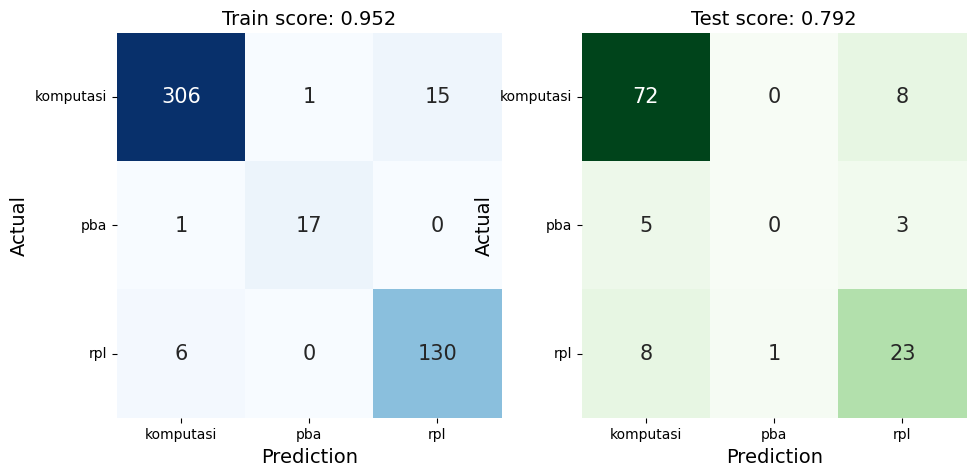

In [72]:
plot_confusion_matrix(X_train, y_train, X_test, y_test, model_naive_1)

#### Word2Vec dan Tanpa PCA

In [80]:
pipeline = Pipeline([
    # ('pca', PCA(n_components=100)),
    ('algo', GaussianNB())
])

model_naive_2 = RandomizedSearchCV(pipeline, {}, cv=4, n_iter=50, n_jobs=-1, verbose=1, random_state=42)
model_naive_2.fit(X_train_vec, y_train_vec)

print(f'best_parameter: {model_naive_2.best_params_}')
print(model_naive_2.score(X_train_vec, y_train_vec), model_naive_2.best_score_, model_naive_2.score(X_test_vec, y_test_vec))

Fitting 4 folds for each of 1 candidates, totalling 4 fits
best_parameter: {}
0.7899159663865546 0.7899159663865545 0.7583333333333333


##### Evaluasi

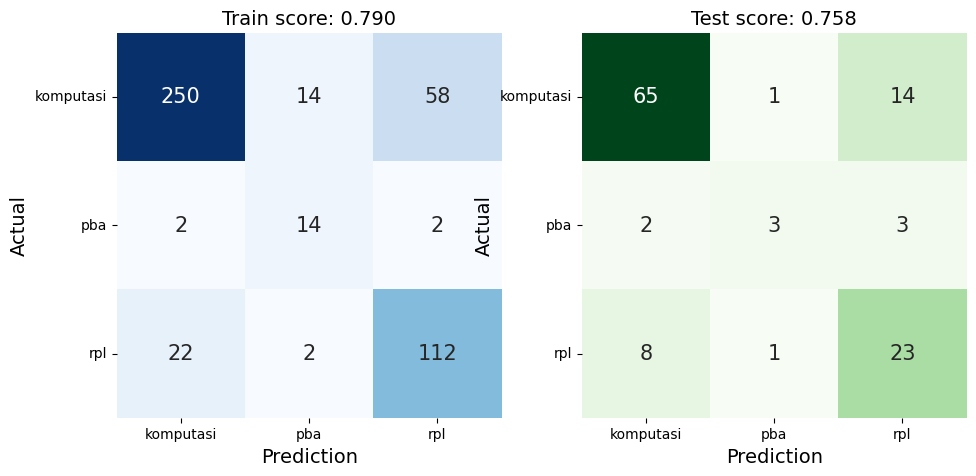

In [83]:
plot_confusion_matrix(X_train_vec, y_train_vec, X_test_vec, y_test_vec, model_naive_2)

#### Word2Vec dan PCA

In [85]:
pipeline = Pipeline([
    ('pca', PCA(n_components=100)),
    ('algo', GaussianNB())
])

model_naive_3 = RandomizedSearchCV(pipeline, {}, cv=4, n_iter=50, n_jobs=-1, verbose=1, random_state=42)
model_naive_3.fit(X_train_vec, y_train_vec)

print(f'best_parameter: {model_naive_3.best_params_}')
print(model_naive_3.score(X_train_vec, y_train_vec), model_naive_3.best_score_, model_naive_3.score(X_test_vec, y_test_vec))

Fitting 4 folds for each of 1 candidates, totalling 4 fits
best_parameter: {}
0.8592436974789915 0.7121848739495797 0.725


##### Evaluasi

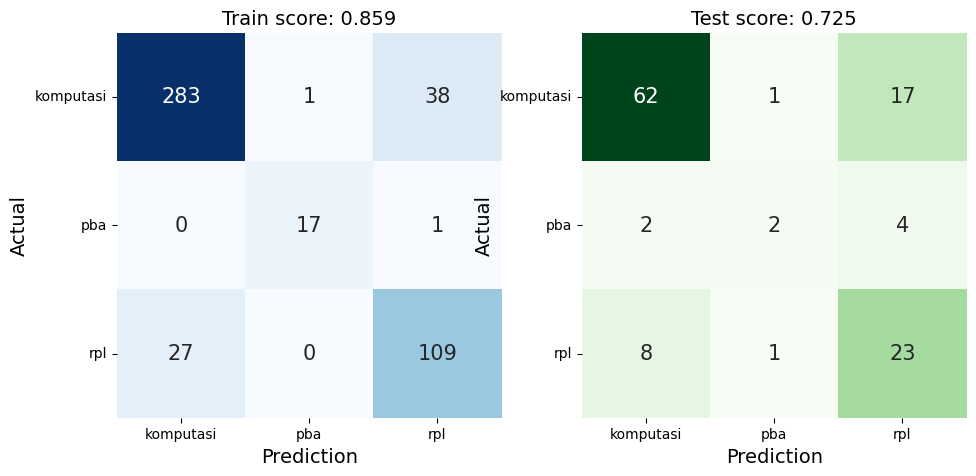

In [86]:
plot_confusion_matrix(X_train_vec, y_train_vec, X_test_vec, y_test_vec, model_naive_3)

### KNN

#### Tanpa Word2Vec dan Tanpa PCA

In [94]:
pipeline = Pipeline([
    ('prep', CountVectorizer()),
    # ('pca', PCA(n_components=)),
    ('algo', KNeighborsClassifier())
])

model_knn_1 = RandomizedSearchCV(pipeline, {}, cv=4, n_iter=50, n_jobs=-1, verbose=1, random_state=42)
model_knn_1.fit(X_train, y_train)

print(f'best_parameter: {model_knn_1.best_params_}')
print(model_knn_1.score(X_train, y_train), model_knn_1.best_score_, model_knn_1.score(X_test, y_test))

Fitting 4 folds for each of 1 candidates, totalling 4 fits
best_parameter: {}
0.8613445378151261 0.7163865546218489 0.725


##### Evaluasi

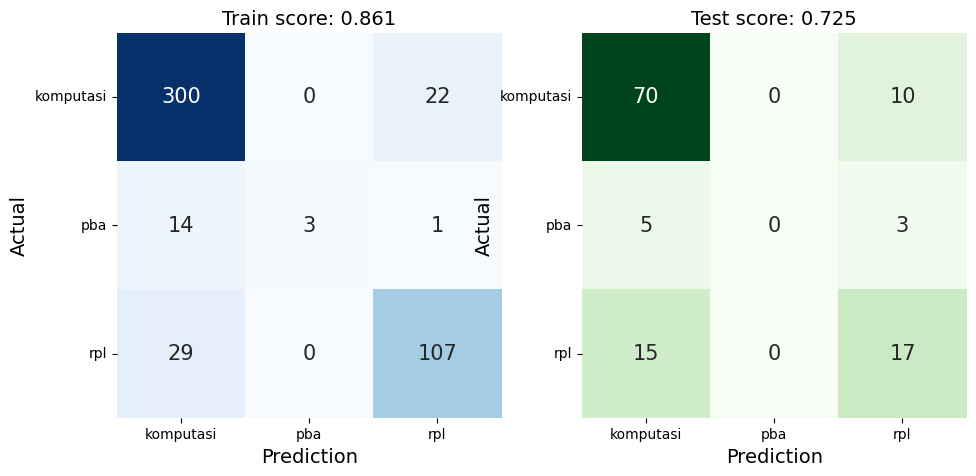

In [96]:
plot_confusion_matrix(X_train, y_train, X_test, y_test, model_knn_1)

#### Word2Vec dan Tanpa PCA

In [97]:
pipeline = Pipeline([
    # ('pca', PCA(n_components=100)),
    ('algo', KNeighborsClassifier())
])

model_knn_2 = RandomizedSearchCV(pipeline, {}, cv=4, n_iter=50, n_jobs=-1, verbose=1, random_state=42)
model_knn_2.fit(X_train_vec, y_train_vec)

print(f'best_parameter: {model_knn_2.best_params_}')
print(model_knn_2.score(X_train_vec, y_train_vec), model_knn_2.best_score_, model_knn_2.score(X_test_vec, y_test_vec))

Fitting 4 folds for each of 1 candidates, totalling 4 fits
best_parameter: {}
0.8571428571428571 0.7920168067226891 0.775


##### Evaluasi

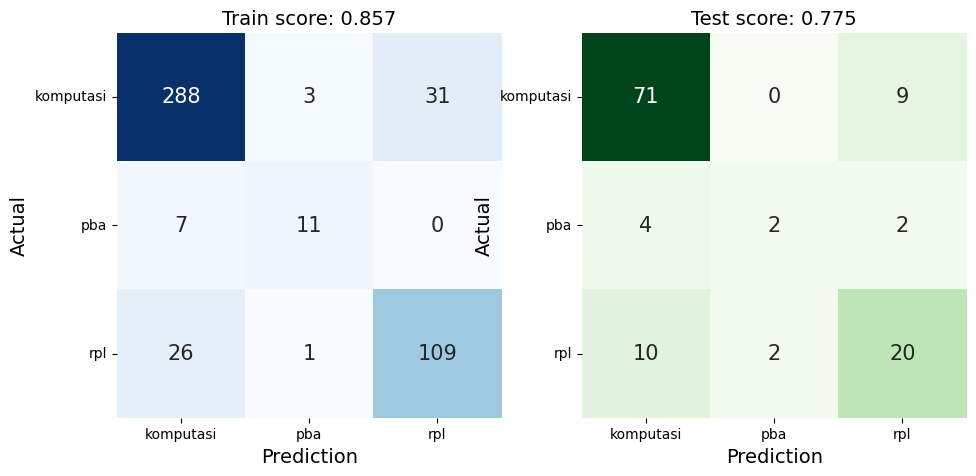

In [98]:
plot_confusion_matrix(X_train_vec, y_train_vec, X_test_vec, y_test_vec, model_knn_2)

#### Word2Vec dan PCA

In [99]:
pipeline = Pipeline([
    ('pca', PCA(n_components=100)),
    ('algo', KNeighborsClassifier())
])

model_knn_3 = RandomizedSearchCV(pipeline, {}, cv=4, n_iter=50, n_jobs=-1, verbose=1, random_state=42)
model_knn_3.fit(X_train_vec, y_train_vec)

print(f'best_parameter: {model_knn_3.best_params_}')
print(model_knn_3.score(X_train_vec, y_train_vec), model_knn_3.best_score_, model_knn_3.score(X_test_vec, y_test_vec))

Fitting 4 folds for each of 1 candidates, totalling 4 fits
best_parameter: {}
0.8592436974789915 0.796218487394958 0.775


##### Evaluasi

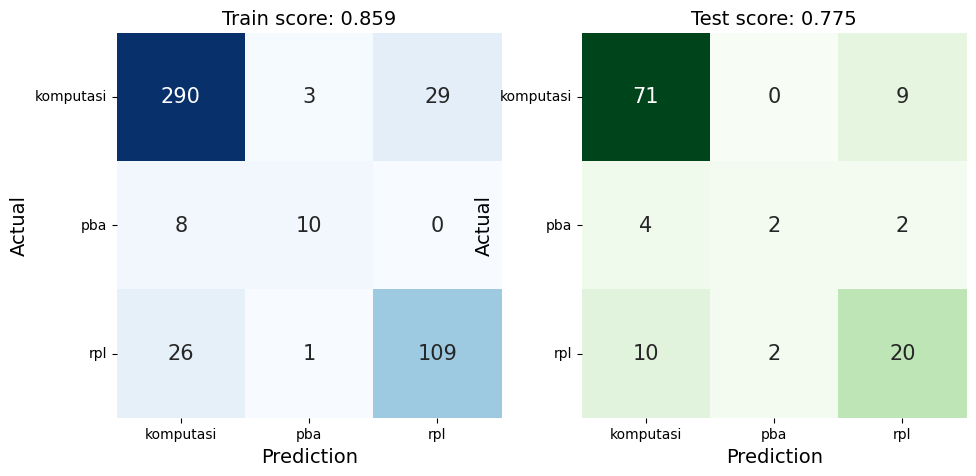

In [100]:
plot_confusion_matrix(X_train_vec, y_train_vec, X_test_vec, y_test_vec, model_knn_3)